In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(143)

In [ ]:
stock_price = pd.read_csv("stock_data_2_yrs_daywise.csv")
stock_price.set_index('Date', inplace = True)

returns = (stock_price - stock_price.shift(1))/stock_price.shift(1)
returns.dropna(axis = 0, inplace = True)
returns.head()

,AdaniPorts,Ambuja,Apollo,AxisBank,Bajaj,BoB,Bata,BlueStar,Camlin,Castrol,...,SteelAuth,sunPharma,TataComm,TataSteel,Titan,Ultramarine,Wipro,Wonderla,YesBank,Nilkamal
Date,,,,,,,,,,,,,,,,,,,,,
01-Sep-23,-0.027492,-0.018092,0.007811,-0.018739,0.002547,-0.019895,-0.001284,-0.004227,-0.000662,0.019359,...,-0.066243,0.001982,-0.037178,-0.042685,-0.001284,-0.001129,-0.026376,0.018740,-0.030460,0.014803
31-Aug-23,0.029038,0.039667,0.012918,0.009138,-0.030779,0.024038,-0.010797,0.003976,0.006623,-0.012086,...,0.006699,-0.001079,0.002812,-0.005270,-0.010797,-0.037288,0.002463,0.002290,-0.000593,0.019937
30-Aug-23,0.030337,-0.002032,0.004464,-0.001831,-0.015114,0.000261,0.000195,-0.006712,-0.030592,0.000699,...,-0.033381,0.012511,-0.007718,-0.020782,0.000195,0.017488,0.004913,0.008350,0.002966,-0.057087
29-Aug-23,-0.022914,-0.007691,-0.005333,0.010091,0.005899,-0.007823,-0.009419,-0.013447,-0.011876,0.014321,...,-0.012527,-0.001244,0.023641,-0.013733,-0.009419,0.003461,0.000000,-0.009843,-0.005914,-0.005775
28-Aug-23,0.006621,-0.005471,-0.006255,-0.008073,-0.007937,-0.001051,0.005590,-0.035616,-0.016140,-0.000344,...,-0.020571,-0.010413,-0.006478,-0.013080,0.005590,-0.062651,0.006845,-0.001815,0.005949,-0.009894


In [ ]:
from scipy.optimize import minimize
r = np.array(returns)

exp_returns = r.mean(axis = 0)
stddev_returns = r.std(axis = 0)
covariance_matrix = np.array(returns.cov())

def obj_function(xi) :
  return (((r - exp_returns)*xi).sum(axis = 1)).sum()/r.shape[0]
target_return = 0.1
initial_weights = [1/50]*50

constraints = [
    {'type': 'eq', 'fun': lambda w: sum(w)-1, 'args':()},
    {'type': 'ineq', 'fun': lambda w: sum(w*exp_returns) - target_return}
]

In [ ]:
result = minimize(obj_function, initial_weights, constraints = constraints)
print("MinMax portfolio weights: ")
print(result.x)
print("MinMax portfolio returns: ", np.sum(result.x * exp_returns))

MinMax portfolio weights: 
[ 0.0129876  -0.04334112 -0.21803611 -0.12525076 -0.00944126 -0.34883747
 -0.27321623  0.26558921 -0.28713481  0.02926611 -0.10521753 -0.22292945
  0.15815926 -0.07328493 -0.02115295 -0.29019922  0.0788211  -0.07024152
 -0.01665831 -0.05708962  0.13947384 -0.60765399  0.06789657  1.97134744
 -0.3861272  -0.11655545 -0.50366799 -0.43772872  0.58127121 -0.29947802
 -0.22314652  0.3544886  -0.17447109  0.01991356  0.13061054 -0.55791868
 -0.68174526 -0.04685016 -0.30669612 -0.13300273  0.19928509 -0.23304004
 -0.11130592  4.5555207  -0.27321623 -0.055262    0.15650304 -0.41352946
 -0.03362818  0.03592119]
MinMax portfolio returns:  0.0999999972694877


In [ ]:
def MAD_portfolio(target_return, shortsell = True):
  obj_fn = lambda xi: (((r - exp_returns)*xi).sum(axis = 1)).sum()/r.shape[0]
  initial_weights = [1/50]*50
  constraints = [
      {'type': 'eq', 'fun': lambda w: sum(w) - 1, 'args': ()},
      {'type': 'ineq', 'fun': lambda w: sum(exp_returns*w) - target_return}
  ]
  if not shortsell:
    bounds = [(0, None)]*(len(initial_weights)) #all positive
    result = minimize(obj_fn, initial_weights, constraints = constraints, bounds = bounds)
  else:
    result = minimize(obj_fn, initial_weights, constraints = constraints)
  return result.x

def Minmax_portfolio(target_return, shortsell = True):
  obj_fn = lambda xi: np.max(np.abs(xi - exp_returns))
  initial_weights = [1/50]*50
  constraints = [
      {'type': 'eq', 'fun': lambda w: sum(w) - 1, 'args': ()},
      {'type': 'ineq', 'fun': lambda w: sum(w*exp_returns) - target_return}
  ]
  if not shortsell:
    bounds = [(0, None)]*(len(initial_weights)) #all positive
    result = minimize(obj_fn, initial_weights, constraints = constraints, bounds = bounds)
  else:
    result = minimize(obj_fn, initial_weights, constraints = constraints)
  return result.x

In [ ]:
def Markowitz_portfolio(target_return, shortsell = True):
  obj_fn = lambda xi: np.dot(xi.T, np.dot(covariance_matrix, xi))
  initial_weights = [1/50]*50
  constraints = [
      {'type': 'eq', 'fun': lambda w: sum(w) - 1, 'args': ()},
      {'type': 'ineq', 'fun': lambda w: sum(w*exp_returns) - target_return}
  ]
  if not shortsell:
    bounds = [(0, None)]*(len(initial_weights)) #all positive
    result = minimize(obj_fn, initial_weights, constraints = constraints, bounds = bounds)
  else:
    result = minimize(obj_fn, initial_weights, constraints = constraints)
  return result.x

In [ ]:
def risk_return(weights):
  risk = np.dot(weights.T, np.dot(covariance_matrix, weights))
  returns = np.dot(weights.T, exp_returns)
  return risk, returns

In [ ]:
w1 = MAD_portfolio(0.1, True)
risk_return(w1)

(3.056213993941731, 0.0999999972694877)

In [ ]:
w2 = Minmax_portfolio(0.1)
risk_return(w2)

(0.8044797851168234, 0.10000000035520415)

In [ ]:
w3 = Markowitz_portfolio(0,1)
risk_return(w3)

(9.770191275263425e-05, 2.956279962651865e-05)

# Visualizing MinMax, Markowitz, MAD models

In [ ]:
markowitz = []
minmax = []
mad = []

for i in range(5, 35, 2):
  markowitz += [risk_return(Markowitz_portfolio(i/100))]
  minmax += [risk_return(Minmax_portfolio(i/100))]
  mad += [risk_return(MAD_portfolio(i/100))]

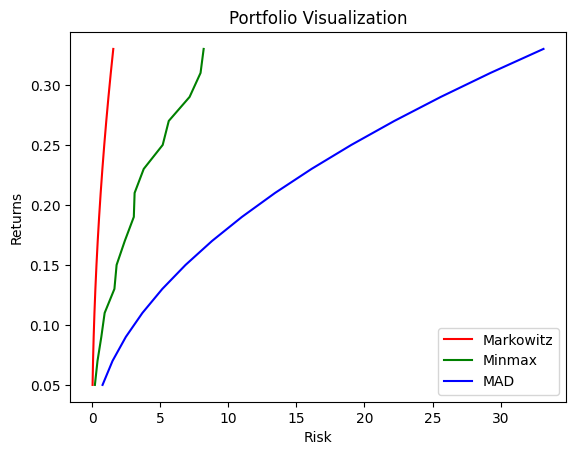

In [ ]:
def plot_line(tuples, colour):
  x_values = [tuple[0] for tuple in tuples]
  y_values = [tuple[1] for tuple in tuples]
  plt.plot(x_values, y_values, color = colour)

plot_line(markowitz, 'red')
plot_line(minmax, 'green')
plot_line(mad, 'blue')

plt.legend(['Markowitz', 'Minmax', 'MAD'])
plt.xlabel('Risk')
plt.ylabel('Returns')
plt.title('Portfolio Visualization')
plt.show()